# Predicitive Maintenance - Machine Failure Classification

This notebook demonstrates how variational quantum machine learning (QML) models, also known as quantum neural networks (QNN), can be trained using the <b>Qiskit Machine Learning</b> library of IBM's Qiskit 1.0 SDK for quantum computing. The code includes two different QML models: On the one hand, the VariationalQuantumClassifier (VQC), which is a convenience implementation resembling classical sklearn ML models in usage; on the other hand, the NeuralNetworkClassifier, which allows for a larger degree of customization. The chosen <b>dataset</b> consists of synthetic data for machine failure prediction created for the following XAI paper:
<br>
<br>
Stephan Matzka. Explainable artificial intelligence for predictive maintenance applications. In <i>2020 Third International Conference on Artificial 
Intelligence for Industries (AI4I)</i>, pages 69–74, Irvine, CA, USA, 2020.
<br>
<br>
A cleaned version of the dataset is publicly available on Kaggle: 
<br>
<br>
Stephan Matzka. Machine predictive maintenance classification dataset. https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification, 2020.
<br>
<br>
Parts of the code are adapted from [tutorials](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/index.html) provided in the Qiskit Machine Learning documentation.

## Environment Setup

We begin by performing necessary imports and configurations:

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import shuffle

In [2]:
# General Qiskit tools
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.quantum_info import SparsePauliOp

# Qiskit Aer simulator
from qiskit_aer.primitives import Estimator
from qiskit_aer import AerSimulator

# Qiskit ML tools
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN

In [3]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
algorithm_globals.random_seed = seed

## Loading and inspecting the data

Next, we load the dataset, which is assumed to be located in the same folder as this notebook. We drop the categorical features 'UDI', 'Product ID', since a one-hot encoding of their individual categories would lead to a large total number of features, which we want to avoid for our simulations. In addition, 'failure type', which is an alternative representation of the target, is dropped as well.

In [4]:
failure_df = pd.read_csv('predictive_maintenance.csv')
failure_df = failure_df.drop(columns=['UDI', 'Product ID', 'Failure Type'])
print(f'Shape of dataset: {failure_df.shape}')

Shape of dataset: (10000, 7)


This leaves us with a dataset of 10.000 samples consisting of a binary target indicating machine failure, 5 numerical features, and one categorical feature. However, since we are mainly interested in showcasing the workflow, we will restrict to dataset size to 1000 samples to shorten training times of the variational QML models. We first check the balance between the two classes in the full dataset:

In [5]:
failure_df['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

We can see that there is a very unequal distribution of classes, i.e., if we draw a random sample from the data, we are far more likely to obtain a non-failure sample compared to obtaining a failure sample (approximately 96.6% vs. 3.4%). Since the business goal is to predict the rare cases of failure, it is advisable to take this imbalance into consideration when reducing the size of the dataset. Thus, we keep all the positive samples. For the remaining 661 samples, we can use the pandas sample() function to effectively implement an undersampling procedure.

In [6]:
# Separate the dataframe into failure and non-failure samples
failure_cases = failure_df[failure_df['Target'] == 1]
non_failure_cases = failure_df[failure_df['Target'] == 0]

# Randomly sample 661 non-failure samples
non_failure_sampled = non_failure_cases.sample(n=661, random_state=seed)

# Concatenate failure cases with the sampled non-failure cases
reduced_df = pd.concat([failure_cases, non_failure_sampled])
# Shuffling
reduced_df = shuffle(reduced_df, random_state=seed).reset_index(drop=True)

print(f'Shape of reduced dataset: {reduced_df.shape}')
print(reduced_df['Target'].value_counts())

Shape of reduced dataset: (1000, 7)
Target
0    661
1    339
Name: count, dtype: int64


Now we can take a look at some descriptive statistics for the numerical features in our reduced dataset:

In [7]:
reduced_df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,300.263900,310.110600,1521.55700,43.358700,118.016000,0.339000
std,2.003932,1.420114,259.54798,13.060058,69.322459,0.473607
min,295.600000,306.100000,1181.00000,3.800000,0.000000,0.000000
25%,298.500000,309.000000,1371.00000,35.200000,57.000000,0.000000
50%,300.400000,310.200000,1455.50000,43.500000,119.500000,0.000000
75%,302.000000,311.100000,1580.25000,52.100000,184.000000,1.000000
max,304.400000,313.700000,2886.00000,76.600000,253.000000,1.000000


Since the features in our dataset differ greatly in their means and standard deviations, we will need to convert them to a standard scale in order to achieve better results with our predictions.

## Pre-processing

Firstly, the pre-built convenience implementation for binary classification in the Qiskit ML library that we will use requires the target values to be $\{ -1, 1 \}$. The reason for this lies in the measurement operation that is applied to retrieve classical values from the variational quantum circuit: The default choice for measuring a single qbit is the Pauli $Z$ matrix, which is written down below.

$$Z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}$$

The eigenvalues of this matrix, which determine the set of possible measurement outcomes, are $\{ -1, 1 \}$. Thus, the encoding of classes needs to be aligned accordingly.

In [8]:
# Replace 0 with -1 in the 'Target' column
reduced_df['Target'] = reduced_df['Target'].replace(0, -1)

For the 'Type' categorical feature, we perform a one-hot encoding, resulting in the replacement of 'Type' by three features 'Type_ . Again we use an encoding in $\{ -1, 1 \}$, which can be seen as more natural for quantum computations.

In [9]:
# Original one-hot encoding
type_encoder = OneHotEncoder(sparse_output=False)
encoded_type = type_encoder.fit_transform(pd.DataFrame(reduced_df['Type']))
# Convert the encoded values from 0 vs 1 to -1 vs 1
encoded_type_df = pd.DataFrame(encoded_type, columns=type_encoder.get_feature_names_out(['Type'])).replace(0, -1)
# Exchange original for encoded columns
encoded_df = pd.concat([reduced_df, encoded_type_df], axis=1).drop(columns=['Type'], axis=1)
encoded_df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M
0,300.4,309.6,1379,54.5,122,-1,-1.0,1.0,-1.0
1,300.2,310.3,1331,52.1,30,-1,-1.0,1.0,-1.0
2,300.7,310.8,1724,30.0,76,-1,-1.0,-1.0,1.0
3,301.6,310.8,1290,65.3,63,-1,-1.0,-1.0,1.0
4,299.1,310.5,1419,48.8,76,-1,-1.0,1.0,-1.0


Next, we separate features and target and use sklearn to perform an 80-10-10% train-validation-test split on our data.

In [10]:
x = np.array(encoded_df.drop(columns=['Target']))
y = np.array(encoded_df['Target'])

# Train-Validation-Test split
x_tr, x_test, y_tr, y_test = train_test_split(x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.5)

To transform all features to a common scale, we can use min-max scaling. Here we have to keep in mind that we later want to encode the classical data we are given into quantum states that can be processed by a variational quantum circuit. In our case, this will be a form of <b>angle encoding</b> where classical data represent angles in parameterized quantum rotation gates. Since using the full range of possible angles in $[0, 2\pi]$ could lead to a misrepresentation of opposite ends of the interval as being close together, we use a min-max scaling to the more restricted interval $[-\frac{\pi}{2}, \frac{\pi}{2}]$. The scaler is fitted only on the training set to avoid data leakage.

In [11]:
# Scaling
scaler = MinMaxScaler(feature_range=(-np.pi / 2, np.pi / 2))
x_tr = scaler.fit_transform(x_tr)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

## Model 1: Qiskit VQC with TwoLocal Ansatz

As our first model, we test the user-friendly VariationalQuantumClassifier (VQC). 

Firstly, we define a function for drawing a live plot of the cost function values achieved during training.

In [12]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, cost_func_eval):
    clear_output(wait=True)
    cost_func_vals.append(cost_func_eval)
    plt.title("Cost function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Cost function value")
    plt.plot(range(len(cost_func_vals)), cost_func_vals)
    plt.show()

Now we can turn to building the model itself. Recall that the variational QML workflow consists of four major steps:
<ul>
    <li><b>Data Encoding: </b> Representation of classical data as quantum states.</li>
    <li><b>Ansatz: </b> Quantum circuit for manipulating the loaded states via parameterized rotations and fixed controlled operators.</li>
    <li><b>Measurement: </b> Retrieval of classical information about the states resulting from application of ansatz.</li>
    <li><b>Cost and Optimization: </b> Choice of an appropriate loss function and optimizer to determine best set of parameters.</li>
</ul>
In the case of Qiskit VQC, however, we only need to explicitly define the first two, and even there we can make use of pre-built Qiskit templates, instead of specifying the gate sequences ourselves. The measurement and cost/optimization steps are taken care of by the VQC internals.

### Data Encoding

To represent our data as quantum states, a popular choice is the <b>ZZ feature map</b>, which we will use here. This is a form of angle encoding where the scaled classical data parameterize $R_Z$ Pauli rotation gates. Furthermore, the Hadamard gate is used to create superposition, and entangling operations are included in this encoding via the $CZ$ operator, which is a controlled two-qbit gate. 
<br>
In Qiskit, we can simply define the ZZFeatureMap circuit template with the desired number of qbits. Here we choose 8 qbits, i.e., one qbit per feature.

In [13]:
num_inputs = x_tr.shape[1]
feature_map = ZZFeatureMap(num_inputs)

### Ansatz

Next, we define our ansatz. The TwoLocal ansatz belongs to the class of hardware-efficient ansätze, since it includes only operations on at most two neighboring qbits. At the same time, it can also be simulated relatively efficiently. Each layer consists of single-qbit rotations, followed by an entangling block with $CNOT$ gates. This pattern may be repeated multiple times before ending with another rotation block.
<br>
In Qiskit, the template for the TwoLocal ansatz allows a free choice of parameterized rotation gates for the rotation block and controlled gates for the entangling block. Furthermore, the number of repetitions and the pattern how the qbits are connected pairwise with the controlled gates can be defined.

In [14]:
twolocal_ansatz = TwoLocal(num_qubits=num_inputs, 
                           rotation_blocks=['ry', 'rz'],
                           entanglement_blocks='cx',
                           entanglement='circular',
                           insert_barriers=False,
                           reps=2)

Qiskit conveniently enables a visualization of the created ansatz:

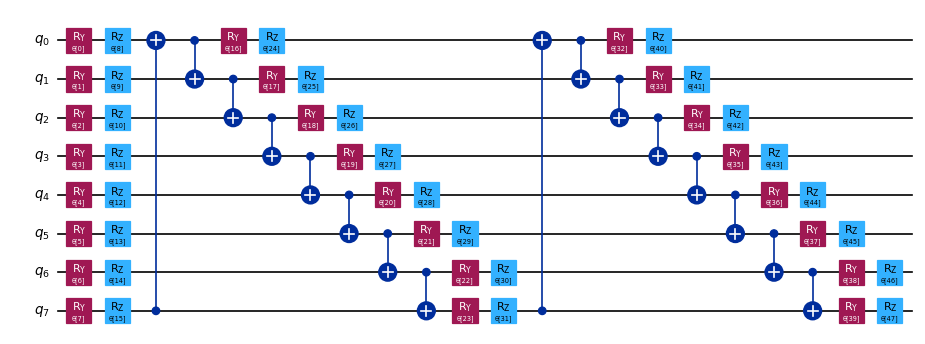

In [15]:
twolocal_qc = QuantumCircuit(num_inputs)
twolocal_qc.compose(twolocal_ansatz, inplace=True)
twolocal_qc.decompose().draw("mpl", scale=0.6)

### Create VQC with data encoding and ansatz

Now we construct the classifier with the defined encoding (feature map) and ansatz. Furthermore, we use binary cross-entropy loss and the COBYLA optimizer with a maximum of 20 iterations for training. At the callback argument, we pass the function for live plotting of training progress. For the measurement operation, a sampler of any Qiskit simulator or of a quantum device available via Qiskit Runtime can be passed. Here we set it to None, which means that an instance of the default Qiskit Sampler primitive will be created.

In [16]:
# construct variational quantum classifier
twolocal_vqc = VQC(
                feature_map=feature_map,
                ansatz=twolocal_ansatz,
                loss="cross_entropy",
                optimizer=COBYLA(maxiter=30),
                callback=callback_graph,
                sampler = None                       # here we could pass a sampler primitive of a real quantum device
)

### Model Training

All that is required to train the VQC is a call to the fit method with the training data as argument.
<br>
<br>
Note: It takes a while until the live plot of training progress starts to show after the first iteration.

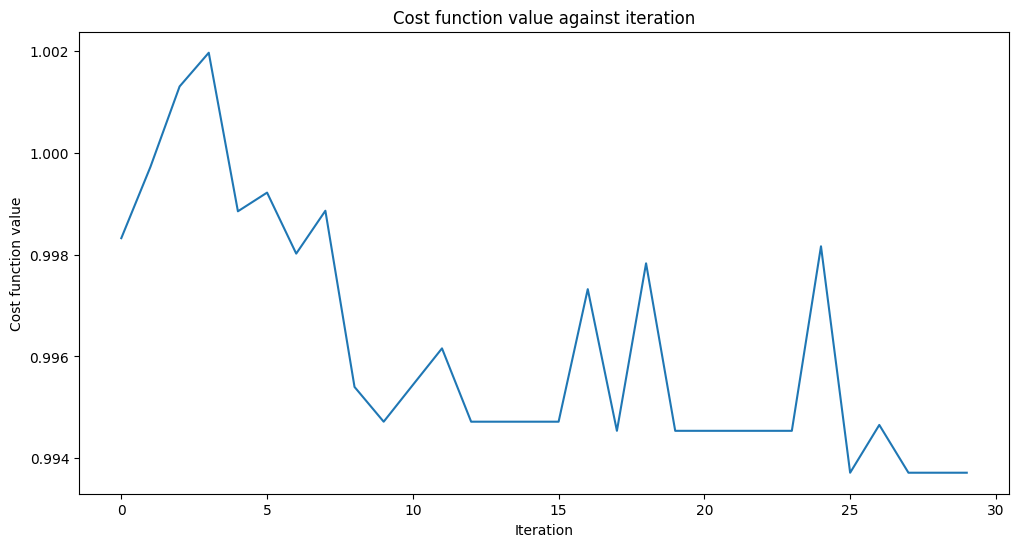

In [17]:
# list to store cost function values for plotting
cost_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
    
# fit classifier to data
twolocal_vqc.fit(x_tr, y_tr)

### Random Forest as classical baseline

Before finally evaluating the VQC, we also train a classical method to enable a comparison. A common choice for binary classification is the Random Forest, which we will use as our baseline. The sklearn implementation with default settings (except the random seed) is trained below.

In [18]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(x_tr, y_tr)

RandomForestClassifier(random_state=42)

### Evaluation of QML and classical ML model

A first intuition about the comparative performance of VQC and Random Forest can be obtained by comparing their accuracy on the validation set.

In [19]:
# score QML classifier
print(f'VQC accuracy on training set: {twolocal_vqc.score(x_tr, y_tr)}')
print(f'VQC accuracy on validation set: {twolocal_vqc.score(x_val, y_val)}')

VQC accuracy on training set: 0.5475
VQC accuracy on validation set: 0.51


In [20]:
# score Random Forest
print(f'RF accuracy on training set: {accuracy_score(rf.predict(x_tr), y_tr)}')
print(f'RF accuracy on validation set: {accuracy_score(rf.predict(x_val), y_val)}')

RF accuracy on training set: 1.0
RF accuracy on validation set: 0.91


We will extend evaluation to other measures incorporating the imbalance of classes once we completed training of the second QML model.

## Model 2: NeuralNetworkClassifier with parameter initialization

The NeuralNetworkClassifier is a variational QML implementation that allows for customizing aspects such as the observable, measurement via sampling or expectation values, initialization of variational parameters, and structure of the training loop. In this part of the notebook, we demonstrate these options step-by-step while reusing the <b> same data encoding and ansatz </b> which we defined before using the ZZFeatureMap and TwoLocal templates.

### Measurement

Our measurement strategy will consist of estimating the expectation value of the Pauli Z observable only on the first qbit in the model's circuit (readout qbit).

In [21]:
# Pauli Z on first qbit and identity on remaining qbits 
obs = SparsePauliOp("Z" + "I"* (x_tr.shape[1]-1))

### Parameter initialization for optimization

Without careful design, the trainability of variational QML methods may be negatively impacted by the phenomenon of <b>barren plateaus</b>, which describes an exponential concentration of gradients leading to a mostly flat optimization landscape. Parameter initialization is one of the factors that are critical in this respect, as investigated by following paper:
<br>
<br>
Muhammad Kashif, Muhammad Rashid, Saif Al-Kuwari, and Muhammad Shafique. Alleviating Barren Plateaus in Parameterized Quantum Machine Learning Circuits: Investigating Advanced Parameter Initialization Strategies. In <i>2024 Design, Automation & Test in Europe Conference & Exhibition (DATE)</i>, pages 1-6, Valencia, IEEE, 2024.
<br>
Also available on arXiv: https://arxiv.org/pdf/2311.13218
<br>
<br>
This study compared the effects of LeCun, Xavier, He, and Orthogonal initialization techniques to random initialization, finding a 62.3% reduction in gradient variance decay for Xavier initialization as best-performing method. Thus, we will demonstrate how to run NeuralNetworkClassifier with a custom parameter initialization scheme, using the Xavier normal initialization as an example. In this method, the weights are drawn from following normal distribution:
<br>
<br>
$\theta \sim \mathcal{N}\left( 0, \frac{2}{n_{in} + n_{out}} \right)$
<br>
<br>
where $n_{in}, n_{out}$ stand for the number of incoming and outgoing connections, respectively. In our case, both are equal to the number of qbits, since we have a circuit of constant width.

In [22]:
# number of parameters we need to initialize
num_parameters = twolocal_ansatz.num_parameters
n_in = num_inputs
n_out = num_inputs

# Xavier Normal
xavier_normal_params = np.random.normal(0, np.sqrt(2 / (n_in + n_out)), num_parameters)

### Model training

Below we define our own training function that builds the NeuralNetworkClassifier with all required ingredients, allowing for a flexible reuse of the code with different inputs. The function concatenates the circuits for data encoding and ansatz, associates them with a measurement strategy in the EstimatorQNN, and trains the classifier with the provided parameter initialization. We again use binary cross-entropy loss and the COBYLA optimizer with maximum 30 iterations.

In [23]:
def train_classifier(init_params, samples, labels, featuremap, ansatz, obs, estimator):

    """
    Parameters:
        init_params (nparray): Array of ansatz parameter initializations
        samples (nparray): Passed samples
        labels (nparray): True labels
        featuremap (QuantumCircuit): Circuit for encoding data as quantum states
        ansatz (QuantumCircuit): Parameterized ansatz circuit 
        obs (SparsePauliOp): Observable
        estimator (EstimatorV1): Primitive for computing expectation value

    Returns:
        classifier (NeuralNetworkClassifier): Trained QNN Classifier
    """

    # compose them as QNN circuit
    qc = QNNCircuit(feature_map = featuremap,
                    ansatz = twolocal_ansatz)

    # build EstimatorQNN with above circuit
    # input and weight parameters are inferred automatically from circuit
    qnn = EstimatorQNN(circuit=qc,
                        estimator=estimator,
                        observables=[obs])
    
    # use pre-built wrapper class for training
    classifier = NeuralNetworkClassifier(neural_network=qnn,
                                         loss='cross_entropy',
                                         optimizer=COBYLA(maxiter=30),
                                         initial_point=init_params,
                                         callback=callback_graph           #again visualize training progress
                                        )   
    
    # fit to training data
    classifier.fit(samples, labels)
    return classifier

Both simulation and execution on quantum devices work via Sampler (for measurement shots) and Estimator (for expectation values) primitives in Qiskit 1.0 or higher. For the following experiment, we use the estimator provided by the high-performance simulator Qiskit Aer, which would also allow advanced options like working with noise models of real quantum hardware.

In [24]:
# Use Qiskit Aer for higher performance compared to Qiskit SDK primitives
estimator = Estimator()

Now we run our training function using the Aer simulator and the Xavier normal initialization:

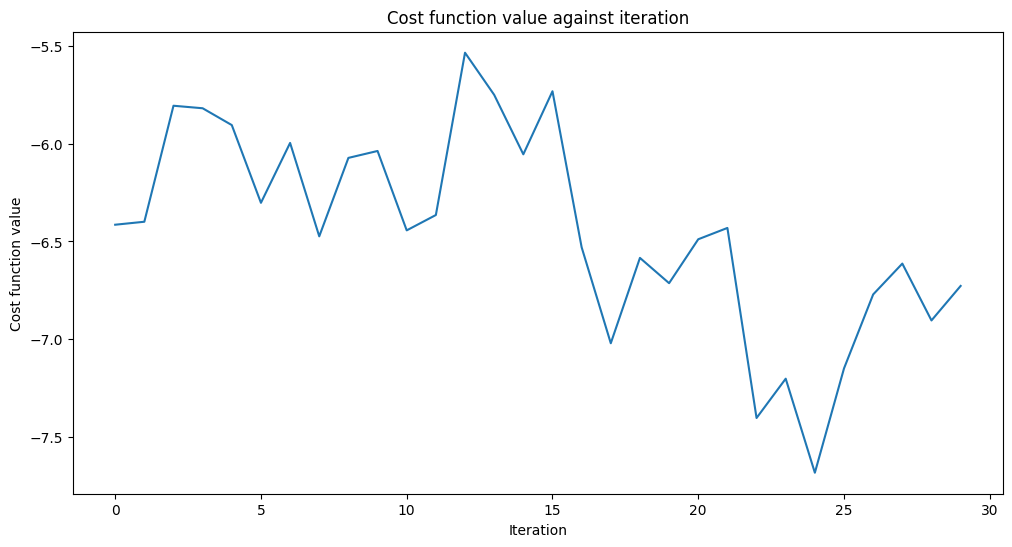

In [25]:
# list to store cost function values for plotting
cost_func_vals = [] 

qnn_classifier = train_classifier(init_params=xavier_normal_params, 
                                  samples=x_tr, 
                                  labels=y_tr, 
                                  featuremap=feature_map, 
                                  ansatz=twolocal_ansatz,
                                  obs=obs, 
                                  estimator=estimator)

## Detailed Evaluation of all three models

For a realistic evaluation of our QML models, we need to:
<ul>
    <li>compare their performance against the Random Forest baseline</li>
    <li>compute a set of alternative measures that reflects the business goal of identifying the rare machine failures better than accuracy</li>
</ul>

In [26]:
# Get model predictions on validation set
rf_val_preds = rf.predict(x_val)
vqc_val_preds = twolocal_vqc.predict(x_val)
qnn_val_preds = qnn_classifier.predict(x_val)

In [27]:
print("Classical Baseline - Random Forest:")
pd.DataFrame(classification_report(y_val, rf_val_preds, output_dict=True))

Classical Baseline - Random Forest:


,-1,1,accuracy,macro avg,weighted avg
precision,0.967213,0.820513,0.91,0.893863,0.917335
recall,0.893939,0.941176,0.91,0.917558,0.910000
f1-score,0.929134,0.876712,0.91,0.902923,0.911311
support,66.000000,34.000000,0.91,100.000000,100.000000


In [28]:
print("Quantum Model 1 - VQC:")
pd.DataFrame(classification_report(y_val, vqc_val_preds, output_dict=True))

Quantum Model 1 - VQC:


,-1,1,accuracy,macro avg,weighted avg
precision,0.680851,0.358491,0.51,0.519671,0.571248
recall,0.484848,0.558824,0.51,0.521836,0.510000
f1-score,0.566372,0.436782,0.51,0.501577,0.522311
support,66.000000,34.000000,0.51,100.000000,100.000000


In [30]:
print("Quantum Model 2 - NeuralNetworkClassifier:")
pd.DataFrame(classification_report(y_val, qnn_val_preds, output_dict=True, zero_division=0))

Quantum Model 2 - NeuralNetworkClassifier:


,-1.0,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.772727,0.0,0.436364,0.58,0.403030,0.658364
recall,0.515152,0.0,0.705882,0.58,0.407011,0.580000
f1-score,0.618182,0.0,0.539326,0.58,0.385836,0.591371
support,66.000000,0.0,34.000000,0.58,100.000000,100.000000


In [31]:
np.where(qnn_val_preds == 0)

(array([25], dtype=int64), array([0], dtype=int64))

For the NeuralNetworkClassifier, we can see that there is one sample in the validation set with a prediction of 0, instead of -1 or 1. This can occur if the expectation value obtained from running the variational circuit for inference is 0. Since 0 is exactly in the middle between the labels -1 and 1, the prediction value lies exactly in between - the classifier is indecisive.

For the <b>overall evaluation</b>, we can see that our classical Random Forest baseline is superior in every way. Its only limitation from a business perspective is that it still performs relatively worse on the positive class, which we would like to identify correctly. This pattern can also be observed for both QML models. In relation to this, we would be especially <b>interested in high recall</b>, keeping the business logic of the case in mind. Focusing on this metric, we can see that Random Forest identified almost all positive samples (94.1%), followed by the NeuralNetworkClassifier (70.6%) and VQC (55.9%). Thus, we can see that using a more customized QML model with a deliberately chosen paramater initialization strategy paid off with an almost 15% increase in recall compared to the default implementation. In conclusion, we have seen that variational QML models can not be expected to work as well as typical classical ML methods like Random Forest when applied in an out-of-the-box manner.

## Outlook

How could we proceed from here with more QML experiments?

<ul>
    <li>Try other data encodings or ansätze that are available as Qiskit templates</li>
    <li>Compare the effects of using other optimizers than COBYLA</li>
    <li>Adapt the NeuralNetworkClassifier with other measurement strategies (choice of observable, SamplerQNN instead of EstimatorQNN)</li>
    <li>Implement the other parameter initialization options from the paper by Kashif et al.</li>
    <li>Use Qiskit ML's connector to PyTorch to build hybrid models </li>
    <li>and many more!</li>
</ul>

Links:
<br>
[Qiskit circuit library](https://docs.quantum.ibm.com/api/qiskit/circuit_library)
<br>
[Qiskit ML TorchConnector](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.connectors.TorchConnector.html#qiskit_machine_learning.connectors.TorchConnector)